In [81]:
from text_embedder import TextEmbedder
from gensim import corpora, models
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# load pre-trained data
business = pd.read_csv('../data/chinese_business_clean.csv')
reviews = pd.read_csv('../data/chinese_reviews_clean_offsets.csv')
reviews['date_tuple'] = [eval(i) for i in reviews['date_tuple']]

# load gensim model
lda =  models.LdaModel.load('../data/gensim/lda.model')
dictionary = corpora.Dictionary.load('../data/gensim/chinsese_dict.dict')

# load idf matrices
with open('../data/u_idf.pickle', 'rb') as f:
    uidf_data = pickle.load(f)
with open('../data/b_idf.pickle', 'rb') as f:
    bidf_data = pickle.load(f)

In [3]:
embedder = TextEmbedder(model = lda, dictionary = dictionary, user_idf = uidf_data, business_idf = bidf_data)

In [11]:
reviews.groupby('business_id').count().reset_index().sort_values(by = 'review_id', ascending = False).head(7)

,business_id,quater,quater_avg,review_id,stars,text,user_id,offset,date_tuple,business_stars,business_offset,quater_offset
3691,yfxDa8RFOvJPQh0rNtakHA,2380,2380,2380,2380,2380,2380,2380,2380,2380,2380,2380
3087,pH0BLkL4cbxKzu471VZnuA,1948,1948,1948,1948,1948,1948,1948,1948,1948,1948,1948
1944,X8c23dur0ll2D9XTu-I8Qg,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525
953,GJ_bXUPv672YwNg4TneJog,1302,1302,1302,1302,1302,1302,1302,1302,1302,1302,1302
2312,cHdJXLlKNWixBXpDwEGb_A,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246,1246
2143,_j2EtQtgLuXGRBfbM5YwZA,897,897,897,897,897,897,897,897,897,897,897
727,CCRgGKhzxSpl38w7yhqKUw,848,848,848,848,848,848,848,848,848,848,848


In [131]:
case1 = reviews[reviews['business_id'] == 'yfxDa8RFOvJPQh0rNtakHA']
case2 = reviews[reviews['business_id'] == 'pH0BLkL4cbxKzu471VZnuA']
case3 = reviews[reviews['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg']
case4 = reviews[reviews['business_id'] == 'GJ_bXUPv672YwNg4TneJog']
case5 = reviews[reviews['business_id'] == 'cHdJXLlKNWixBXpDwEGb_A']

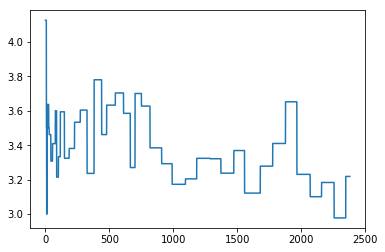

In [27]:
plt.plot(case1.sort_values(by= 'quater')['quater_avg'].values)
plt.show()

## Can xgb perform well to predict business offset

In [33]:
def mapping(x):
    if x < 0:
        return 0
    else:
        return int(x!=0)+1

In [73]:
# try basic methods with January of 2013 - 2017
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['business_offset'] != 0]
    label = [mapping(b) for b in data['business_offset']]
    # create labels
    if enum == 0: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 1: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 2: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 5:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

In [55]:
%time x0, y0 = embed_by_enum(case1, embedder, enum = 0)

CPU times: user 29.2 s, sys: 126 ms, total: 29.3 s
Wall time: 27.4 s


In [56]:
%time x1, y1 = embed_by_enum(case1, embedder, enum = 1)

CPU times: user 29.8 s, sys: 111 ms, total: 29.9 s
Wall time: 28 s


In [59]:
%time x2, y2 = embed_by_enum(case1, embedder, enum = 2)

CPU times: user 30.4 s, sys: 129 ms, total: 30.5 s
Wall time: 28.7 s


In [60]:
%time x3, y3 = embed_by_enum(case1, embedder, enum = 3)

CPU times: user 29.9 s, sys: 89.7 ms, total: 30 s
Wall time: 28.1 s


In [74]:
%time x_base, y_base = embed_by_enum(case1, embedder, enum = 4)

CPU times: user 24.4 s, sys: 388 ms, total: 24.8 s
Wall time: 6.25 s


In [75]:
%time x_base_s, y_base_s = embed_by_enum(case1, embedder, enum = 5)

CPU times: user 28.3 s, sys: 75.1 ms, total: 28.4 s
Wall time: 26.5 s


## Baseline 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(x_base, y_base, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [84]:
def cmat_to_accuracy(mat):
    size = len(mat)
    total = sum(sum(mat))
    correct = 0
    for i in range(size):
        correct += mat[i,i]
    return correct/total

In [85]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[118,  39],
       [103, 216]])

In [86]:
cmat_to_accuracy(m)

0.70168067226890751

## Baseline2

In [138]:
X_train, X_test, y_train, y_test = train_test_split(x_base_s, y_base_s, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [139]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[135,  37],
       [ 92, 212]])

In [140]:
cmat_to_accuracy(m)

0.72899159663865543

## Embedding1

In [141]:
X_train, X_test, y_train, y_test = train_test_split(x0, y0, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [142]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[139,  55],
       [ 89, 193]])

In [143]:
cmat_to_accuracy(m)

0.69747899159663862

## Embedding2

In [144]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [145]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[132,  58],
       [ 91, 195]])

In [146]:
cmat_to_accuracy(m)

0.68697478991596639

## Embedding3

In [147]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [148]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[139,  43],
       [ 97, 197]])

In [149]:
cmat_to_accuracy(m)

0.70588235294117652

## Embedding4

In [150]:
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [151]:
m = confusion_matrix(model.predict(X_test), y_test)
m

array([[125,  54],
       [ 86, 211]])

In [152]:
cmat_to_accuracy(m)

0.70588235294117652

In [162]:
def experiments(xs, ys, models):
    for x, y, mod in zip(xs,ys,models):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        model = XGBClassifier()
        model.fit(X_train, y_train)
        m = confusion_matrix(model.predict(X_test), y_test)
        print (str(mod) + ' : {}'.format(cmat_to_accuracy(m)))

In [165]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.726890756302521
base2 : 0.7058823529411765
embedding1 : 0.7247899159663865
embedding2 : 0.6932773109243697
embedding3 : 0.7247899159663865
embedding4 : 0.6785714285714286


In [166]:
x0, y0 = embed_by_enum(case2, embedder, enum = 0)
x1, y1 = embed_by_enum(case2, embedder, enum = 1)
x2, y2 = embed_by_enum(case2, embedder, enum = 2)
x3, y3 = embed_by_enum(case2, embedder, enum = 3)
x_base, y_base = embed_by_enum(case2, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case2, embedder, enum = 5)

In [167]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.5564102564102564
base2 : 0.5307692307692308
embedding1 : 0.5487179487179488
embedding2 : 0.5128205128205128
embedding3 : 0.5512820512820513
embedding4 : 0.558974358974359


In [168]:
x0, y0 = embed_by_enum(case3, embedder, enum = 0)
x1, y1 = embed_by_enum(case3, embedder, enum = 1)
x2, y2 = embed_by_enum(case3, embedder, enum = 2)
x3, y3 = embed_by_enum(case3, embedder, enum = 3)
x_base, y_base = embed_by_enum(case3, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case3, embedder, enum = 5)

In [169]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.7016393442622951
base2 : 0.6622950819672131
embedding1 : 0.6885245901639344
embedding2 : 0.7081967213114754
embedding3 : 0.6459016393442623
embedding4 : 0.6426229508196721


In [170]:
x0, y0 = embed_by_enum(case4, embedder, enum = 0)
x1, y1 = embed_by_enum(case4, embedder, enum = 1)
x2, y2 = embed_by_enum(case4, embedder, enum = 2)
x3, y3 = embed_by_enum(case4, embedder, enum = 3)
x_base, y_base = embed_by_enum(case4, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case4, embedder, enum = 5)

In [171]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.6130268199233716
base2 : 0.6053639846743295
embedding1 : 0.6053639846743295
embedding2 : 0.5938697318007663
embedding3 : 0.6283524904214559
embedding4 : 0.6436781609195402


In [172]:
x0, y0 = embed_by_enum(case5, embedder, enum = 0)
x1, y1 = embed_by_enum(case5, embedder, enum = 1)
x2, y2 = embed_by_enum(case5, embedder, enum = 2)
x3, y3 = embed_by_enum(case5, embedder, enum = 3)
x_base, y_base = embed_by_enum(case5, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case5, embedder, enum = 5)

In [173]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.512
base2 : 0.504
embedding1 : 0.488
embedding2 : 0.496
embedding3 : 0.484
embedding4 : 0.5


## Can the model predict quater offset?

In [177]:
x0, y0 = embed_by_enum(case5, embedder, enum = 0)
x1, y1 = embed_by_enum(case5, embedder, enum = 1)
x2, y2 = embed_by_enum(case5, embedder, enum = 2)
x3, y3 = embed_by_enum(case5, embedder, enum = 3)
x_base, y_base = embed_by_enum(case5, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case5, embedder, enum = 5)

In [178]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.672
base2 : 0.688
embedding1 : 0.656
embedding2 : 0.624
embedding3 : 0.684
embedding4 : 0.668


In [179]:
x0, y0 = embed_by_enum(case1, embedder, enum = 0)
x1, y1 = embed_by_enum(case1, embedder, enum = 1)
x2, y2 = embed_by_enum(case1, embedder, enum = 2)
x3, y3 = embed_by_enum(case1, embedder, enum = 3)
x_base, y_base = embed_by_enum(case1, embedder, enum = 4)
x_base_s, y_base_s = embed_by_enum(case1, embedder, enum = 5)

In [180]:
experiments([x_base,x_base_s,x0,x1,x2,x3], [y_base,y_base_s,y0,y1,y2,y3], ['base1','base2','embedding1','embedding2', 'embedding3', 'embedding4'])

base1 : 0.7605042016806722
base2 : 0.7205882352941176
embedding1 : 0.7247899159663865
embedding2 : 0.7058823529411765
embedding3 : 0.7226890756302521
embedding4 : 0.680672268907563
